<a href="https://colab.research.google.com/github/mralamdari/Computer-Vision-Projects/blob/main/Arthropod_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [Arthropod Taxonomy Orders Object Detection Dataset](https://www.kaggle.com/datasets/mistag/arthropod-taxonomy-orders-object-detection-dataset/)



###### Lepidoptera = butterfies and moths
###### Hymenoptera = wasps, bees and ants
###### Hemiptera = true bugs (cicadas, aphids, shield bugs, ...)
###### Odonata = dragonflies
###### Diptera = fies
###### Araneae = spiders
###### Coleoptera = beetles

###### NOT IN DATASET
###### Orthoptera = grasshoppers

In [1]:
import os
import re
import sys
import json
import time
import numpy as np
import pprint as pp
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib as mpl
import concurrent.futures
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt


AUTO = tf.data.AUTOTUNE
pp = pp.PrettyPrinter()

!pip install --quiet tf-models-official==2.9.2
sys.path.append('PATH_TO_TENSORFLOW_OBJECT_DETECTION_FOLDER')# load all the metadata

import tensorflow_models as tfm
from tensorflow_models.vision import box_ops as box

     |████████████████████████████████| 2.1 MB 7.8 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 4.6 MB 44.9 MB/s 
     |████████████████████████████████| 1.1 MB 56.2 MB/s 
     |████████████████████████████████| 662 kB 43.3 MB/s 
     |████████████████████████████████| 238 kB 13.4 MB/s 
     |████████████████████████████████| 118 kB 61.6 MB/s 
     |████████████████████████████████| 352 kB 62.7 MB/s 
     |████████████████████████████████| 1.3 MB 57.7 MB/s 


In [2]:
os.environ['KAGGLE_CONFIG_DIR']='/content/drive/MyDrive/'
!kaggle datasets download -d mistag/arthropod-taxonomy-orders-object-detection-dataset
!unzip *.zip && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: ArTaxOr/Lepidoptera/c9b07301ed0e.jpg  
  inflating: ArTaxOr/Lepidoptera/c9d742746b8a.jpg  
  inflating: ArTaxOr/Lepidoptera/c9d78061b77d.jpg  
  inflating: ArTaxOr/Lepidoptera/ca2ff8921244.jpg  
  inflating: ArTaxOr/Lepidoptera/ca338092c0ec.jpg  
  inflating: ArTaxOr/Lepidoptera/ca35e5c89d94.jpg  
  inflating: ArTaxOr/Lepidoptera/ca4cb66fcd4a.jpg  
  inflating: ArTaxOr/Lepidoptera/ca5e1fe4cbc0.jpg  
  inflating: ArTaxOr/Lepidoptera/ca5e2a4139c0.jpg  
  inflating: ArTaxOr/Lepidoptera/ca63af0a9774.jpg  
  inflating: ArTaxOr/Lepidoptera/ca652f69b2e7.jpg  
  inflating: ArTaxOr/Lepidoptera/ca95914f205e.jpg  
  inflating: ArTaxOr/Lepidoptera/ca997241704b.jpg  
  inflating: ArTaxOr/Lepidoptera/cb0ad7fb32fa.jpg  
  inflating: ArTaxOr/Lepidoptera/cb0aec5a6b79.jpg  
  inflating: ArTaxOr/Lepidoptera/cb134256077c.jpg  
  inflating: ArTaxOr/Lepidoptera/cb22cb2317b4.jpg  
  inflating: ArTaxOr/Lepidoptera/cb35eb6c2e67.jpg  
  inflating: 

# [Data Exploring](https://www.kaggle.com/code/mistag/starter-arthropod-taxonomy-orders-data-exploring)

The Arthropod Taxonomy Orders dataset is a collection of highres images annotated with labels from the taxanomy rank order. Annotations have been made with VoTT. VoTT stores all metadata in json files. In this kernel we will import all the metadata into DataFrames and export metadata to a variety of formats for object detection model training.
The dataset is distributed under CC BY-NC-SA 4.0

In [3]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import glob

pfiles = glob.glob('/content/ArTaxOr/**/*.vott', recursive=True)

df = pd.DataFrame()
for p in pfiles:
  print(p)
  with open(p) as f:
    pdata = json.load(f)
    print(pdata)
    df = df.append(pd.DataFrame(list(pdata['assets'].values())), ignore_index=True)

df['path'] = df['path'].str.replace('file:F:/', '')

/content/ArTaxOr/Odonata/annotations/Odonata.vott
{'name': 'Odonata', 'securityToken': 'Diptera Token', 'sourceConnection': {'name': 'Odonata', 'providerType': 'localFileSystemProxy', 'providerOptions': {'encrypted': 'eyJjaXBoZXJ0ZXh0IjoiODY0NWJmNDA1NDNjOGVlYmZhZDQzZTliYzU4NjM0MjliZDcyNjRlODJhYzRkODNhNGFhMzhiY2U2N2UyYmFjOTU3MmY4NWEzYWVkYjI0ODAwODU3MGExOWUyMzRmZWQ4IiwiaXYiOiI1ZDkzYjc2MWI5ZTg2MzUxOWVlYzlkYmIzZjNkMTA3ODUyZmIyOTlmY2ZmZWExYWMifQ=='}, 'id': 'Ko1s85UOf'}, 'targetConnection': {'name': 'Odonata annotations', 'providerType': 'localFileSystemProxy', 'providerOptions': {'encrypted': 'eyJjaXBoZXJ0ZXh0IjoiOGVkNTIwMDU5OGM0NWE1MDY2MzgwMTE1MTkxMGMyNDcxNjI4ZWRjOGQ4M2EwMzQ3OTU0NmU3NmE0MDY4MTZmNGNhNDAzODFhMjliNWJlODM3NzQ0MjEyOTdjZjc4NmNhODhhZWQzNDdhZGRiZmZiNTIwODY2MDRmN2Y0ZTczNTUiLCJpdiI6IjUyYTgzMTBlOWRlNWViNjVjMzU5ODFiYWFjYmMxYWMwYzE3NzMzMGQ1MTU2MmNjMyJ9'}, 'id': 'csXqIsO36'}, 'videoSettings': {'frameExtractionRate': 15}, 'tags': [{'name': 'Lepidoptera', 'color': '#5db300'}, {'name': 'Co

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [5]:
df

format                                id              name  \
0        jpg  1311647201897a4d3647190ad0dc1c79  012f05204bbc.jpg   
1        jpg  0b41be9ec913af601f8c4f97de7ccc57  023aa60255f3.jpg   
2        jpg  e9213b52e2d461ad6edb8df4883ddd21  02a004bd1829.jpg   
3        jpg  36232dd40ab42cf7e1f48835d51ba7d0  034b7a89da90.jpg   
4        jpg  c614ed50aa8b7d6817953a99b67cf46a  06f29a5862a8.jpg   
...      ...                               ...               ...   
15371    jpg  b93f699edaca6f530dc3e8947fad5ff8  ffb481aa387b.jpg   
15372    jpg  712734ee3b8758e035f0508c1dc02a20  ffccefbbe8b5.jpg   
15373    jpg  da43816d3025b6c7b3621ba9f12d384b  ffe588f6175a.jpg   
15374    jpg  bd5f1e8ea1f12dba35acdf7d5940a614  ffed0c32db73.jpg   
15375    jpg  643f81cde19c56011cd7a4a6ff023a20  c8e73aa60865.jpg   

                                       path                             size  \
0          ArTaxOr/Odonata/012f05204bbc.jpg  {'width': 2628, 'height': 3504}   
1          ArTaxOr/Odonata/023aa60255f3.jpg  {'width': 2415, 'height': 1854}   
2          ArTaxOr/Odonata/02a004bd1829.jpg  {'width': 1920, 'height': 1280}   
3          ArTaxOr/Odonata/034b7a89da90.jpg  {'width': 1920, 'height': 1280}   
4          ArTaxOr/Odonata/06f29a5862a8.jpg  {'width': 1920, 'height': 1275}   
...                                     ...                              ...   
15371  ArTaxOr/Lepidoptera/ffb481aa387b.jpg  {'width': 2445, 'height': 3456}   
15372  ArTaxOr/Lepidoptera/ffccefbbe8b5.jpg  {'width': 3872, 'height': 2592}   
15373  ArTaxOr/Lepidoptera/ffe588f6175a.jpg  {'width': 4608, 'height': 3456}   
15374  ArTaxOr/Lepidoptera/ffed0c32db73.jpg  {'width': 4272, 'height': 2848}   
15375  ArTaxOr/Lepidoptera/c8e73aa60865.jpg  {'width': 4078, 'height': 3276}   

       state  type  
0          2     1  
1          2     1  
2          2     1  
3          2     1  
4          2     1  
...      ...   ...  
15371      2     1  
15372      2     1  
15373      2     1  
15374      2     1  
15375      2     1  

[15376 rows x 7 columns]

In [6]:
labels = pd.DataFrame(list(pdata['tags']))[:-3]
labels

name    color
0  Lepidoptera  #5db300
1   Coleoptera  #e81123
2  Hymenoptera  #6917aa
3      Diptera  #015cda
4      Araneae  #4894fe
5    Hemiptera  #257ffe
6      Odonata  #257ffe

In [7]:
p = 'ArTaxOr/Diptera/fff86b0ae807.jpg'
index = p[::-1].find('/')+1
p[:-index]

'ArTaxOr/Diptera'

In [8]:
anno=pd.DataFrame(columns=['label', 'label_idx', 'xres', 'yres', 'height', 'width', 'left', 'top', 
                           'right', 'bottom', 'area', 'xcenter', 'ycenter', 'blurred',
                           'occluded', 'truncated', 'file', 'id'])


#get all the image's annotation details (object data) from a json file and store it in a dataframe
for i in range(len(df)):  #15376 images(with details)
  p = df['path'][i]
  index = p[::-1].find('/')+1
  json_file=f'/content/{p[:-index]}/annotations/{df["id"][i]}-asset.json'

  if os.path.isfile(json_file):
    with open(json_file) as f:
      adata = json.load(f)
    xres=adata['asset']['size']['width']
    yres=adata['asset']['size']['height'] 
    for j in range(len(adata['regions'])):
            h=adata['regions'][j]['boundingBox']['height']/yres
            w=adata['regions'][j]['boundingBox']['width']/xres
            tags=adata['regions'][j]['tags']
            anno=anno.append({'label': tags[0],
                              'label_idx': labels[labels.name==tags[0]].index[0],
                              'xres': xres,
                              'yres': yres,
                              'height': h,
                              'width': w,                              
                              'left': adata['regions'][j]['boundingBox']['left']/xres,
                              'top': adata['regions'][j]['boundingBox']['top']/yres,
                              'right': adata['regions'][j]['boundingBox']['left']/xres+w,
                              'bottom': adata['regions'][j]['boundingBox']['top']/yres+h, 
                              'area': h*w,
                              'xcenter': adata['regions'][j]['boundingBox']['left']/xres+0.5*w,
                              'ycenter': adata['regions'][j]['boundingBox']['top']/yres+0.5*h,
                              'blurred': int(any(ele == '_blurred' for ele in tags)),
                              'occluded': int(any(ele == '_occluded' for ele in tags)),
                              'truncated': int(any(ele == '_truncated' for ele in tags)),
                              'file': adata['asset']['path'].replace('file:F:/',''),
                              'id': adata['asset']['id'],}, ignore_index=True)

In [9]:
anno.sample(5)

label label_idx  xres  yres    height     width      left  \
10535   Coleoptera         1  1152  2048  0.393678  0.637138  0.039395   
16760  Lepidoptera         0  1920  1280  0.302999  0.109580  0.324604   
10153   Coleoptera         1  2048  1536  0.684866  0.782328  0.087284   
6647       Diptera         3  5184  3456  0.309204  0.252929  0.369400   
4522   Hymenoptera         2  2918  2188  0.440613  0.393678  0.320885   

            top     right    bottom      area   xcenter   ycenter blurred  \
10535  0.340038  0.676533  0.733716  0.250827  0.357964  0.536877       0   
16760  0.361605  0.434183  0.664604  0.033203  0.379394  0.513104       0   
10153  0.121648  0.869612  0.806513  0.535789  0.478448  0.464080       0   
6647   0.405038  0.622329  0.714242  0.078207  0.495865  0.559640       0   
4522   0.345785  0.714563  0.786398  0.173460  0.517724  0.566092       0   

      occluded truncated                                  file  \
10535        0         0   ArTaxOr/Coleoptera/e6d5188b8089.jpg   
16760        0         0  ArTaxOr/Lepidoptera/11936ea0c19f.jpg   
10153        0         0   ArTaxOr/Coleoptera/c49c3ab2e8aa.jpg   
6647         0         0      ArTaxOr/Diptera/6d543f7045db.jpg   
4522         0         0  ArTaxOr/Hymenoptera/a82d6aeab167.jpg   

                                     id  
10535  0982df12a1940ff3f87d970340bd95b6  
16760  e7f8379a6885c636f8138c16679cd847  
10153  0c099dff4e588780bd28beaa496a4c7c  
6647   17f5ddcdda1b04287cbcb37a75c7127e  
4522   7d298bddeb48ac058d3d0f08058881ff

In [10]:
# sns.relplot(x="width", y="height", hue="label", col="label", data=anno)

In [11]:
# sns.jointplot(x='width', y='height', data=anno.loc[anno['label'] == 'Diptera'])

In [12]:
sns.set(rc={'figure.figsize': (12,6)})
# sns.violinplot(x=anno['label'], y=anno['area'])

In [13]:
# graph=sns.countplot(data=anno, x='label')
# graph.set_xticklabels(graph.get_xticklabels(), rotation=90)

# for p in graph.patches:
#   height = p.get_height()
#   graph.text(p.get_x() + p.get_width()/2, height + 0.1, height, ha='center')

In [14]:
temp = 'truncated'
df2 = anno[['label', temp]]
df2 = df2.loc[df2[temp] == 1]
# sns.countplot(x=temp, hue='label', data=df2)

In [15]:
temp = 'blurred'
df2 = anno[['label', temp]]
df2 = df2.loc[df2[temp] == 1]
# sns.countplot(x=temp, hue='label', data=df2)

In [16]:
temp = 'occluded'
df2 = anno[['label', temp]]
df2 = df2.loc[df2[temp] == 1]
# sns.countplot(x=temp, hue='label', data=df2)

## Image exploration


In [17]:
def attribution(fname):
    img = Image.open(fname)
    exif_data = img._getexif()
    img.close()
    if len(exif_data[315]) > 0:
        s='Photo: '+exif_data[315]
    else:
        s=exif_data[37510][8:].decode('ascii')
    return s

def plot_img(axes, image_df, highlight=True):
    image_file_name='/content/'+image_df.iloc[0].file
    im = Image.open(image_file_name)
    im.thumbnail((300,300),Image.ANTIALIAS)  #A small image representation of a larger image
    draw = ImageDraw.Draw(im)
    xres, yres = im.size[0], im.size[1] # X, Y Resolution
    for i in range(len(image_df)):
        selected_img = image_df.iloc[i]
        if highlight==True:
            color=(255, 0, 0) if i == 0 else (128, 128, 128)          
        else:
            color=labels[labels.name == selected_img.label].color.iloc[0]
        
        #draw a boundingbox
        draw.rectangle([int(selected_img['left']*xres),
                        int(selected_img['top']*yres),
                        int(selected_img['right']*xres),
                        int(selected_img['bottom']*yres)], outline=color, width=2)
        
    plt.setp(axes, xticks=[], yticks=[])  #remove the grids
    axes.set_title(image_df.iloc[0].label+'\n'+attribution(image_file_name))
    plt.imshow(im)

In [18]:
fig = plt.figure(figsize=(16,26))
for i in range(len(labels)):
  for j in range(3):
    #Select 3 images with the largest area
    # ldf=anno[anno.label == labels.name[i]].nlargest(3, 'area') 

    #Select images with the most objects
    a=anno[anno.label == labels.name[i]]['id'].value_counts()
    ldf=anno[anno.id == a.index[j]]
    # axes = fig.add_subplot(len(labels), 3, 1+i*3+j)
    # plot_img(axes, anno[anno.id == ldf.iloc[j].id].sort_values(by=['area'], ascending=False), highlight=False)

<Figure size 1152x1872 with 0 Axes>

# Metadata export

export metadata to various formats for object detection model training


## CSV

In [19]:
header = ['file', 'label', 'height', 'width', 'left', 'top', 'right', 'bottom'] # change as required
anno.to_csv('./ArTaxOr.csv', index=False, columns = header) 

## Pascal VOC

Pascal VOC files are xml format, and there is one xml file per image file, with same name.

In [20]:
!{sys.executable} -m pip install pascal_voc_writer
from pascal_voc_writer import Writer

if not os.path.exists('voc'):
    os.mkdir('voc')

for i in range(len(df)):
    ldf=anno[anno.id == df.id[i]].reset_index()
    p=df.path[i].split('/')
    image_xml = p[2].replace('.jpg','.xml') 
    width, height = ldf.xres[0], ldf.yres[0]
    
    writer = Writer(df.path[i], width, height)
    for j in range(len(ldf)):
        writer.addObject(ldf.label[j], 
                         int(ldf.left[j]*width), 
                         int(ldf.top[j]*height), 
                         int(ldf.right[j]*width),
                         int(ldf.bottom[j]*height))
    writer.save(f'./voc/{image_xml}')
# print(os.listdir("./voc"))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Darknet YOLOv3
Darknet expects one annotation file per image file. Each object is described by:

`class x_center y_center width height`

In [21]:
if not os.path.exists('labels'):
    os.mkdir('labels')

for i in range(len(df)):
    ldf=anno[anno.id == df.id[i]].reset_index()
    p=df.path[i].split('/') 
    image_txt = p[2].replace('.jpg','.txt') 
    
    file=open(f'./labels/{image_txt}','w')
    for j in range(len(ldf)):
        label_name=labels[labels.name == ldf.label[j]].index.to_list()
        file.write(f'{label_name[0]} {ldf.xcenter[j]} {ldf.ycenter[j]} {ldf.width[j]} {ldf.height[j]}\n')
    file.close()
# print(os.listdir("./labels"))

## Pickle

In [22]:
labels.to_pickle('./ArTaxOr_labels.pkl')
df.to_pickle('./ArTaxOr_filelist.pkl')
anno.to_pickle('./ArTaxOr_objects.pkl')

## [TensorFlow TFRecords](https://www.kaggle.com/code/mistag/tensorflow-tfrecords-demystified/notebook)

#### Protocol buffers
TFRecords are Protocol buffers. Protocol buffers are a way of serializing structured data in a compact and efficient way. A Protocol buffer message is defined by a .proto file. Example:

```
syntax = "proto3"; // define protocol version

// Define "Employee" message with 3 fields
message Employee {
 string name = 1; // a unique number is assigned to each field
 int32 company_id = 2;
 string address = 3;
}

```


A single .proto-file can define multiple messages and messages can be nested. The beauty of protocol buffers is that the .proto-files can be compiled into a library (language of choice) with access functions using the protoc compiler. But for TFRecords the access functions we need are already part of TensorFlow, so no need to worry about compiling .proto files.

### TFRecord format with simple data
TFRecords are made to support just about any type of data, and that means nesting basic features into a hierarchy of features.TFRecords supports only three different data types:

bytes
float
int64

So any data must be converted into one of these three types.

In [23]:
# tf.train.Feature can be used to convert data into lists of these types.
int_list = tf.train.Feature(int64_list=tf.train.Int64List(value=np.arange(8)))
int_list

int64_list {
  value: 0
  value: 1
  value: 2
  value: 3
  value: 4
  value: 5
  value: 6
  value: 7
}

In [24]:
float_list = tf.train.Feature(float_list=tf.train.FloatList(value=np.random.rand(10)))
float_list

float_list {
  value: 0.6992796063423157
  value: 0.9081366658210754
  value: 0.29698872566223145
  value: 0.9009175300598145
  value: 0.3193792998790741
  value: 0.28884702920913696
  value: 0.5693294405937195
  value: 0.16647224128246307
  value: 0.928915798664093
  value: 0.8872254490852356
}

In [25]:
bytes_list = tf.train.Feature(bytes_list=tf.train.BytesList(value=['hello, my name is Esmail'.encode()]))
bytes_list

bytes_list {
  value: "hello, my name is Esmail"
}

In [26]:
features = tf.train.Features(feature={
    'integers': int_list,
    'float': float_list,
    'description': bytes_list
})
features

feature {
  key: "description"
  value {
    bytes_list {
      value: "hello, my name is Esmail"
    }
  }
}
feature {
  key: "float"
  value {
    float_list {
      value: 0.6992796063423157
      value: 0.9081366658210754
      value: 0.29698872566223145
      value: 0.9009175300598145
      value: 0.3193792998790741
      value: 0.28884702920913696
      value: 0.5693294405937195
      value: 0.16647224128246307
      value: 0.928915798664093
      value: 0.8872254490852356
    }
  }
}
feature {
  key: "integers"
  value {
    int64_list {
      value: 0
      value: 1
      value: 2
      value: 3
      value: 4
      value: 5
      value: 6
      value: 7
    }
  }
}

The last step is to create an example TFRecord. So, example is not a very good name, but that is what the TFRecord is called. We simply pass the list of features to `tf.train.Example.`

In [27]:
tf_record = tf.train.Example(features=features)
tf_record

features {
  feature {
    key: "description"
    value {
      bytes_list {
        value: "hello, my name is Esmail"
      }
    }
  }
  feature {
    key: "float"
    value {
      float_list {
        value: 0.6992796063423157
        value: 0.9081366658210754
        value: 0.29698872566223145
        value: 0.9009175300598145
        value: 0.3193792998790741
        value: 0.28884702920913696
        value: 0.5693294405937195
        value: 0.16647224128246307
        value: 0.928915798664093
        value: 0.8872254490852356
      }
    }
  }
  feature {
    key: "integers"
    value {
      int64_list {
        value: 0
        value: 1
        value: 2
        value: 3
        value: 4
        value: 5
        value: 6
        value: 7
      }
    }
  }
}

 write this record to a file using tf.io.TFRecordWriter

In [28]:
fname='example1.tfrecord'
with tf.io.TFRecordWriter(fname) as writer:
    writer.write(tf_record.SerializeToString())
print(f"Size of {fname} is {os.path.getsize(fname)} bytes")

Size of example1.tfrecord is 144 bytes


Next, read the file back in and access the data using tf.data.TFRecordDataset and tf.train.Example.FromString:

In [29]:
dataset = tf.data.TFRecordDataset(fname)
raw_example = next(iter(dataset))
parsed = tf.train.Example.FromString(raw_example.numpy())
parsed

features {
  feature {
    key: "description"
    value {
      bytes_list {
        value: "hello, my name is Esmail"
      }
    }
  }
  feature {
    key: "float"
    value {
      float_list {
        value: 0.6992796063423157
        value: 0.9081366658210754
        value: 0.29698872566223145
        value: 0.9009175300598145
        value: 0.3193792998790741
        value: 0.28884702920913696
        value: 0.5693294405937195
        value: 0.16647224128246307
        value: 0.928915798664093
        value: 0.8872254490852356
      }
    }
  }
  feature {
    key: "integers"
    value {
      int64_list {
        value: 0
        value: 1
        value: 2
        value: 3
        value: 4
        value: 5
        value: 6
        value: 7
      }
    }
  }
}

Access each feature using `parsed.features.feature['<feature name>']`



In [30]:
parsed.features.feature['description'].bytes_list.value[0].decode()

'hello, my name is Esmail'

In [31]:
parsed.features.feature['integers'].int64_list.value[:]

[0, 1, 2, 3, 4, 5, 6, 7]

In [32]:
parsed.features.feature['float'].float_list.value[:]

[0.6992796063423157,
 0.9081366658210754,
 0.29698872566223145,
 0.9009175300598145,
 0.3193792998790741,
 0.28884702920913696,
 0.5693294405937195,
 0.16647224128246307,
 0.928915798664093,
 0.8872254490852356]

### TFRecords with image data

To make input function efficient, all preprocessing steps should be performed when creating TFRecords, otherwise the input function must repeat preprocessing each time the training passed over the TFRecord. Typical preprocessing steps are:

#### Decode image from jpg etc.
#### Resize image
#### Convert to float
#### Normalize to [0,1] range

Augumentation is not something to do in a TFRecord, since agumentation could be different each time training passes over the data

In [33]:
import hashlib
from io import BytesIO
from PIL import Image, ImageFont, ImageDraw
ARTAXOR_PATH = '/content/'

pickles='/content/'
objectdf=pd.read_pickle(pickles+'ArTaxOr_objects.pkl')
labels=pd.read_pickle(pickles+'ArTaxOr_labels.pkl')
objectdf.sample(5)

label label_idx  xres  yres    height     width      left  \
9904    Coleoptera         1  2048  1584  0.608238  0.706667  0.163275   
2726   Hymenoptera         2  1892  1229  0.417815  0.325293  0.281875   
8890    Coleoptera         1  1360  2048  0.892720  0.611833  0.206552   
14199    Hemiptera         5  1718  1717  0.756705  0.663158  0.140969   
10609   Coleoptera         1  1734  1734  0.252874  0.253831  0.338602   

            top     right    bottom      area   xcenter   ycenter blurred  \
9904   0.217433  0.869942  0.825670  0.429821  0.516609  0.521552       0   
2726   0.270712  0.607167  0.688527  0.135912  0.444521  0.479620       0   
8890   0.064176  0.818385  0.956897  0.546195  0.512468  0.510536       0   
14199  0.117816  0.804127  0.874521  0.501815  0.472548  0.496169       0   
10609  0.388889  0.592433  0.641762  0.064187  0.465517  0.515326       0   

      occluded truncated                                  file  \
9904         0         0   ArTaxOr/Coleoptera/adbc92b51b01.jpg   
2726         0         0  ArTaxOr/Hymenoptera/110dbfb89585.jpg   
8890         0         0   ArTaxOr/Coleoptera/4d8b5136022a.jpg   
14199        0         0    ArTaxOr/Hemiptera/3a0b7558cb1e.jpg   
10609        0         0   ArTaxOr/Coleoptera/ed8e22391098.jpg   

                                     id  
9904   00dd66874595f191071c3786edca7ea2  
2726   bfda76de5ee6b6253d145a7e3df40d96  
8890   6c0083872fd74c7f2ace37e1b5deba76  
14199  ecaa90a6a4edb547a7ec00c8042df260  
10609  812b07f4de216d57ae10c32b5544811a

Define a function that creates a tf.train.Example from an image and the objects contained within.

    Note that TensorFlow Object Detection API expects jpeg-encoded image data

, so the only preprocessing to be done is resize (optional) before the image is re-encoded (via a memory buffer using BytesIO).


The input to this function is a DataFrame that contains one row per object and the columns shown above. This record is generous with features, but that is to make sure that the TF Object Detection API will successfully run the evaluation phase during training.

In [34]:
# Fetch attribution string from image EXIF data
def get_attribution(file):
    with Image.open(file) as img:
        exif_data = img._getexif()
    
    source ='Photo: unknown'
    if exif_data is not None:
        if 37510 in exif_data and len(exif_data[37510]) > 0:
            source = exif_data[37510][8:].decode('ascii')
        if 315 in exif_data and len(exif_data[315]) > 0:
            source = 'Photo: ' + exif_data[315]
    return source

# Create example for TensorFlow Object Detection API
def create_tf_example(imagedf, longest_edge=1024):  
    fname = ARTAXOR_PATH+imagedf.file.iloc[0]  #exclude image path 
    filename=fname.split('/')[-1]              #exclude image name
    by = get_attribution(fname)                #exclude EXIF data
    img = Image.open(fname, "r")

    # resize image if larger that longest edge while keeping aspect ratio
    if max(img.size) > longest_edge:
        img.thumbnail((longest_edge, longest_edge), Image.ANTIALIAS)
    
    width, height = img.size #(w, h)

    buf= BytesIO()
    img.save(buf, format= 'JPEG') # encode to jpeg in memory
    encoded_image_data= buf.getvalue()
    image_format = b'jpeg'
    
    source_id = filename.split('.')[0]
    license = 'CC BY-NC-SA 4.0'
    # A hash of the image is used in some frameworks
    key = hashlib.sha256(encoded_image_data).hexdigest() 

    # object bounding boxes 
    # List of normalized coordinates in bounding box (1 per box)
    xmins, xmaxs, ymins, ymaxs = imagedf[['left', 'right', 'top', 'bottom']].values.T

    # List of string class name & id of bounding box (1 per box)
    object_count = len(imagedf)
    classes_text = []
    classes = []
    for i in range(object_count):
        classes_text.append(imagedf.label.iloc[i].encode())
        classes.append(1 + imagedf.label_idx.iloc[i])

    #??????????????????????????????????????????????????????????????????
    
    # unused features from Open Image 
    depiction = np.zeros(object_count, dtype=int)
    group_of = np.zeros(object_count, dtype=int)
    occluded = imagedf.occluded.values #also Pascal VOC
    truncated = imagedf.truncated.values # also Pascal VOC


    # Pascal VOC
    view_text = []
    for i in range(object_count):
        view_text.append('frontal'.encode())
    difficult = np.zeros(object_count, dtype=int)

    tf_record = tf.train.Example(features=tf.train.Features(feature={
        'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename.encode()])),
        'image/source_id': tf.train.Feature(bytes_list=tf.train.BytesList(value=[source_id.encode()])),
        'image/license': tf.train.Feature(bytes_list=tf.train.BytesList(value=[license.encode()])),
        'image/by': tf.train.Feature(bytes_list=tf.train.BytesList(value=[by.encode()])),
        'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[encoded_image_data])),
        'image/key/sha256': tf.train.Feature(bytes_list=tf.train.BytesList(value=[key.encode()])),
        'image/format': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_format])),
        'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=xmins)),
        'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=xmaxs)),
        'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=ymins)),
        'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=ymaxs)),
        'image/object/class/text': tf.train.Feature(bytes_list=tf.train.BytesList(value=classes_text)),
        'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
        'image/object/depiction': tf.train.Feature(int64_list=tf.train.Int64List(value=depiction)),
        'image/object/group_of': tf.train.Feature(int64_list=tf.train.Int64List(value=group_of)),
        'image/object/occluded': tf.train.Feature(int64_list=tf.train.Int64List(value=occluded)),
        'image/object/truncated': tf.train.Feature(int64_list=tf.train.Int64List(value=truncated)),
        'image/object/difficult': tf.train.Feature(int64_list=tf.train.Int64List(value=difficult)),
        'image/object/view': tf.train.Feature(bytes_list=tf.train.BytesList(value=view_text))
    }))
    return tf_record

In [35]:
#An Example of creating tf record
sample_file='ArTaxOr/Hemiptera/00600a41bcaf.jpg'
imagedf=objectdf[objectdf.file == sample_file]
tfr=create_tf_example(imagedf)
# print(tfr)
fname='./image_ex1.tfrecord'
with tf.io.TFRecordWriter(fname) as writer:
    writer.write(tfr.SerializeToString())
print(f"Size of {fname} is {fname, os.path.getsize(fname)//1024} kbytes")

Size of ./image_ex1.tfrecord is ('./image_ex1.tfrecord', 95) kbytes


load back in and visualize the Tensordlow records contents.

In [36]:
font = ImageFont.load_default()
def bbox(img, xmin, ymin, xmax, ymax, color, width, label, score):
    draw = ImageDraw.Draw(img)

    xres, yres = img.size  #(w, h)

    #box[0] = xmin*xres
    box = np.multiply([xmin, ymin, xmax, ymax], [xres, yres, xres, yres]).astype(int).tolist()

    txt = f" {label}: {round(score, 1)}" if score >= 0. else f" {label}"
    ts = draw.textsize(txt, font=ImageFont.load_default())
    draw.rectangle(box, outline=color, width=width)

    #######????????    
    if len(label) > 0:
        if box[1] >= ts[1]+3:
            xsmin, ysmin = box[0],                box[1]-ts[1]-3
            xsmax, ysmax = box[0] + ts[0] + 2,    box[1]
        else:
            xsmin, ysmin = box[0],               box[3]
            xsmax, ysmax = box[0] + ts[0] + 2,   box[3] + ts[1] + 1
            
        draw.rectangle([xsmin, ysmin, xsmax, ysmax], fill=color)
        draw.text((xsmin, ysmin), txt, font=font, fill='white')

In [37]:
def plot_img(img, axes, xmin, ymin, xmax, ymax, classes, class_label, by):
    for i in range(len(xmin)):
        color=labels.color[class_label[i]-1]
        bbox(img, xmin[i], ymin[i], xmax[i], ymax[i], color, 5, classes[i].decode(), -1)
    plt.setp(axes, xticks=[], yticks=[])
    axes.set_title(by)
    plt.imshow(img)

In [38]:
# load tfrecord
fname='image_ex1.tfrecord'
dataset = tf.data.TFRecordDataset(fname)
img_example = next(iter(dataset))
img_parsed = tf.train.Example.FromString(img_example.numpy())
# only extract features we will actually use
xmin=img_parsed.features.feature['image/object/bbox/xmin'].float_list.value[:]
xmax=img_parsed.features.feature['image/object/bbox/xmax'].float_list.value[:]
ymin=img_parsed.features.feature['image/object/bbox/ymin'].float_list.value[:]
ymax=img_parsed.features.feature['image/object/bbox/ymax'].float_list.value[:]
by=img_parsed.features.feature['image/by'].bytes_list.value[0].decode()
classes=img_parsed.features.feature['image/object/class/text'].bytes_list.value[:]
class_label=img_parsed.features.feature['image/object/class/label'].int64_list.value[:]
img_encoded=img_parsed.features.feature['image/encoded'].bytes_list.value[0]

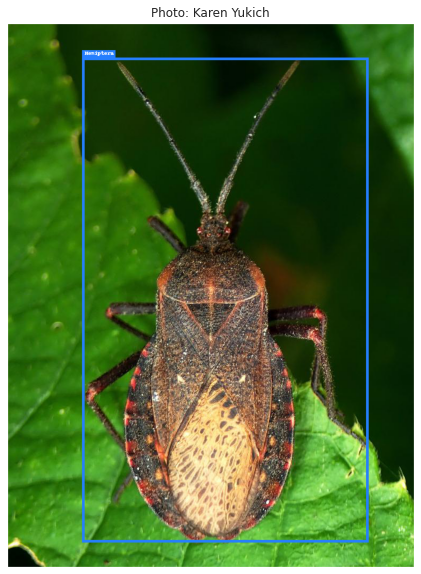

In [39]:
fig = plt.figure(figsize=(10,10))
axes = axes = fig.add_subplot(1, 1, 1)
img = Image.open(BytesIO(img_encoded))
plot_img(img, axes, xmin, ymin, xmax, ymax, classes, class_label, by)

Notice: putting jpeg-encoded images in TFRecords does not release the full potential of TFRecords. If you are training on a machine with fast I/O and lots of disk space, it is better to do all the preprocessing before storing the image as normalized float array. Let's define another function for this:

In [40]:
def create_tf_example2(imagedf, longest_edge=1024):  
    # Filename of the image (full path is useful when there are multiple image directories)
    fname = ARTAXOR_PATH+imagedf.file.iloc[0]  #exclude image path 
    filename=fname.split('/')[-1]              #exclude image name
    by = get_attribution(fname)                #exclude EXIF data
    img = Image.open(fname, "r")
    source_id = filename.split('.')[0]

    # resize image if larger that longest edge while keeping aspect ratio
    if max(img.size) > longest_edge:
        img.thumbnail((longest_edge, longest_edge), Image.ANTIALIAS)

    image_data = np.asarray(img)

    # storing shape will make it easy to reconstruct image later
    image_shape = np.array(image_data.shape)
    # convert to float
    image_data = image_data.reshape(image_data.shape[0] * image_data.shape[1] * image_data.shape[2])
    image_data = image_data.astype(float)/255. # normalize to [0,1]

    # object bounding boxes 
    # List of normalized coordinates in bounding box (1 per box)
    xmins, xmaxs, ymins, ymaxs = imagedf[['left', 'right', 'top', 'bottom']].values.T

    # List of string class name & id of bounding box (1 per box)
    classes_text = []
    classes = []
    for i in range(len(imagedf)):
        classes_text.append(imagedf.label.iloc[i].encode())
        classes.append(1+imagedf.label_idx.iloc[i])

    tf_record = tf.train.Example(features=tf.train.Features(feature={
        'image/shape': tf.train.Feature(int64_list=tf.train.Int64List(value=image_shape)),
        'image/filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename.encode()])),
        'image/source_id': tf.train.Feature(bytes_list=tf.train.BytesList(value=[source_id.encode()])),
        'image/by': tf.train.Feature(bytes_list=tf.train.BytesList(value=[by.encode()])),
        'image/data': tf.train.Feature(float_list=tf.train.FloatList(value=image_data)),
        'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=xmins)),
        'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=xmaxs)),
        'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=ymins)),
        'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=ymaxs)),
        'image/object/class/text': tf.train.Feature(bytes_list=tf.train.BytesList(value=classes_text)),
        'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=classes))
    }))
    return tf_record

In [41]:
sample_file2='ArTaxOr/Hymenoptera/ab30b4c2f70c.jpg'
imagedf=objectdf[objectdf.file == sample_file2]
tfr2 = create_tf_example2(imagedf)
fname2 = 'image_ex2.tfrecord'
with tf.io.TFRecordWriter(fname2) as writer:
    writer.write(tfr2.SerializeToString())
print(f"Size of {fname2} is {os.path.getsize(fname2)//1024} kbytes")

Size of image_ex2.tfrecord is 9768 kbytes


Notice: 

Storing image data as float gives a filesize of almost 10MB while the jpeg-encoded one was only 104kB. But now all preprocessing steps are complete, and the image can be fed directly to training (or possibly agumentation).

In [42]:
dataset2 = tf.data.TFRecordDataset(fname2)
img_example2 = next(iter(dataset2)) 
img_parsed2 = tf.train.Example.FromString(img_example2.numpy())
# extract features
xmin=img_parsed2.features.feature['image/object/bbox/xmin'].float_list.value[:]
xmax=img_parsed2.features.feature['image/object/bbox/xmax'].float_list.value[:]
ymin=img_parsed2.features.feature['image/object/bbox/ymin'].float_list.value[:]
ymax=img_parsed2.features.feature['image/object/bbox/ymax'].float_list.value[:]
by=img_parsed2.features.feature['image/by'].bytes_list.value[0].decode()
classes=img_parsed2.features.feature['image/object/class/text'].bytes_list.value[:]
class_label=img_parsed2.features.feature['image/object/class/label'].int64_list.value[:]
img_shape=img_parsed2.features.feature['image/shape'].int64_list.value[:]
img_data=img_parsed2.features.feature['image/data'].float_list.value[:]

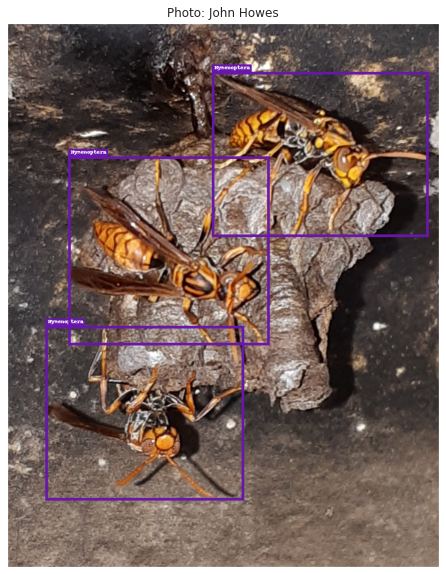

In [43]:
image2=np.array(img_data).reshape(img_shape) # reshape
image2=image2*255. # scale back to [0, 255] and convert to int
image2=image2.astype(int)
img=Image.fromarray(np.uint8(image2))   ###????
fig = plt.figure(figsize=(10,10))
axes = axes = fig.add_subplot(1, 1, 1)
plot_img(img, axes, xmin, ymin, xmax, ymax, classes, class_label, by)

Now, let's consider the case when we have a huge dataset, and need to create multiple TFRecords.

In [44]:
filelist=pd.read_pickle(pickles+'ArTaxOr_filelist.pkl')
filelist=filelist.sample(frac=1)
filelist.head()

format                                id              name  \
4318     jpg  944e8adab5505f781b3b59ac4aa14643  fe8128aba79a.jpg   
14309    jpg  edd07b8ae45b9d5da43b090e1d82738b  806dfc1ac1e2.jpg   
21       jpg  845835182ddca0f107f6946e65130389  168db1a4a87f.jpg   
3145     jpg  8c4e055bc81f000bc6079adfde2b89c3  70009fedd77e.jpg   
2225     jpg  c69be371094cac0d562e31b157d5be35  f992f249202f.jpg   

                                       path                             size  \
4318   ArTaxOr/Hymenoptera/fe8128aba79a.jpg  {'width': 1152, 'height': 2048}   
14309  ArTaxOr/Lepidoptera/806dfc1ac1e2.jpg  {'width': 5184, 'height': 3456}   
21         ArTaxOr/Odonata/168db1a4a87f.jpg  {'width': 1920, 'height': 1080}   
3145   ArTaxOr/Hymenoptera/70009fedd77e.jpg  {'width': 2048, 'height': 1536}   
2225       ArTaxOr/Odonata/f992f249202f.jpg  {'width': 2048, 'height': 1844}   

       state  type  
4318       2     1  
14309      2     1  
21         2     1  
3145       2     1  
2225       2     1

### The contextlib2 library
 is used to automatically close all TFRecords files after writing is finished.



In [ ]:
%%time
import contextlib2

########???????????????????????????
def open_sharded_tfrecords(exit_stack, base_path, num_shards):

    tf_record_output_filenames = [f'{base_path}-{idx:05d}-of-{num_shards:05d}.tfrecord' for idx in range(num_shards)]

    tfrecords = [exit_stack.enter_context(tf.io.TFRecordWriter(file_name)) for file_name in tf_record_output_filenames]

    return tfrecords

num_shards=50
output_filebase='./ArTaxOr'

with contextlib2.ExitStack() as tf_record_close_stack:
    output_tfrecords = open_sharded_tfrecords(tf_record_close_stack, output_filebase, num_shards)
    for i in range(len(filelist)):
        ldf=objectdf[objectdf.id == filelist.id.iloc[i]].reset_index()
        tf_record = create_tf_example(ldf, longest_edge=1280)
        output_shard_index = i % num_shards
        output_tfrecords[output_shard_index].write(tf_record.SerializeToString())

In [ ]:
!ls -lh ArTaxOr*.tfrecord

To use TF Object Detection API, a label definition file is also needed


In [ ]:
labels=pd.read_pickle(pickles+'ArTaxOr_labels.pkl')
pbfile=open('./ArTaxOr.pbtxt', 'w') 
for i in range(len(labels)): 
    pbfile.write(f"item {{\n id: {i+1}\n name:\'{labels.name[i]}\'\n}}\n\n")
pbfile.close()

In [ ]:
## Read a few records from one of the .tfrecord files
fname='./ArTaxOr-00029-of-00050.tfrecord' 
dataset3 = tf.data.TFRecordDataset(fname)
fig = plt.figure(figsize=(16,18))
idx=1
for raw_record in dataset3.take(6):
    axes = fig.add_subplot(3, 2, idx)
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    xmin=example.features.feature['image/object/bbox/xmin'].float_list.value[:]
    xmax=example.features.feature['image/object/bbox/xmax'].float_list.value[:]
    ymin=example.features.feature['image/object/bbox/ymin'].float_list.value[:]
    ymax=example.features.feature['image/object/bbox/ymax'].float_list.value[:]
    by=example.features.feature['image/by'].bytes_list.value[0].decode()
    classes=example.features.feature['image/object/class/text'].bytes_list.value[:]
    class_label=example.features.feature['image/object/class/label'].int64_list.value[:]
    img_encoded=example.features.feature['image/encoded'].bytes_list.value[0]
    img = Image.open(BytesIO(img_encoded))
    # plot_img(img, axes, xmin, ymin, xmax, ymax, classes, class_label, by)
    idx=idx+1

# TF2 Object Detection API

## Install Object Detection API

In [ ]:
!git clone https://github.com/tensorflow/models.git
%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.
!cp object_detection/packages/tf2/setup.py .
!python -m pip install --user .

In [ ]:
# make sure we have the right tf version
!pip install tensorflow==2.4.1
!pip install tensorflow-addons

In [ ]:
# Test the installation

!python object_detection/builders/model_builder_tf2_test.py > test.log

### Hack to enable auto-augmentation
The auto-augmentation policy does not work in the current release, so a hack is made below to make it work.

In [ ]:
%cd /content/models/research/object_detection/utils
!cp autoaugment_utils.py autoaugment_utils.py.org

with open('autoaugment_utils.py.org', 'r') as f:
    txt = f.read()

# hack to make auto_augmentation work
txt = txt.replace('from tensorflow.contrib import image as contrib_image', 'from tensorflow_addons import image as contrib_image')
txt = txt.replace('from tensorflow.contrib import training as contrib_training', 'from collections import namedtuple')
txt = txt.replace('# TODO(barretzoph): Add in ArXiv link once paper is out.', 'def hparams(**kwargs):\n    return namedtuple(\"HParams\", kwargs.keys())(*kwargs.values())\n\n')
txt = txt.replace('augmentation_hparams = contrib_training.HParams(', 'augmentation_hparams = hparams(')

with open('autoaugment_utils.py', 'w') as f:
    f.write(txt)
# copy the file to the installation directory
!cp autoaugment_utils.py /lib/python3.7/site-packages/object_detection/utils/.
%cd /content/models/research

## Install a model from the model garden
Choose from a large selection of object detection models in the [TensorFlow 2 Detection Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md).

In [ ]:
MODEL = "faster_rcnn_resnet50_v1_1024x1024_coco17_tpu-8"

%cd object_detection
!mkdir pre-trained-models
%cd pre-trained-models
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/{MODEL}.tar.gz
!tar -xf {MODEL}.tar.gz
!rm {MODEL}.tar.gz

## Edit pipeline.config
The pipeline.config file is in protocol buffer format, and we can use the config_util to change the settings we need.

In [ ]:
# first make a copy of the original pipeline.config file
%cd /content/models/research/object_detection
!cp /content/models/research/object_detection/pre-trained-models/{MODEL}/pipeline.config \
    /content/models/research/object_detection/pre-trained-models/{MODEL}/pipeline.config.org

In [ ]:
from object_detection.utils import config_util

config = config_util.get_configs_from_pipeline_file(f'/content/models/research/object_detection/pre-trained-models/{MODEL}/pipeline.config.org')

In [ ]:
model_config = config['model']
model_config.faster_rcnn.num_classes = 7
train_config = config['train_config']
train_config.fine_tune_checkpoint = "/content/models/research/object_detection/pre-trained-models/"+MODEL+"/checkpoint/ckpt-0"
# GPU memory limits batch size
train_config.batch_size = 2
train_config.use_bfloat16 = False
# some models use "fine_tune" rather than "detection" for fine-tuning
train_config.fine_tune_checkpoint_type = "detection"
# set auto-augmentation
del train_config.data_augmentation_options[:]
a1=train_config.data_augmentation_options.add()
a1.autoaugment_image.policy_name = "v2"
# training dataset (80%)
train_input_config = config['train_input_config']
train_input_config.label_map_path = "/content/tensorflow-tfrecords-demystified/ArTaxOr.pbtxt"
train_input_config.tf_record_input_reader.input_path[:] = ["/content/tensorflow-tfrecords-demystified/ArTaxOr-????0-of-00050.tfrecord",
                                                           "/content/tensorflow-tfrecords-demystified/ArTaxOr-????2-of-00050.tfrecord",
                                                           "/content/tensorflow-tfrecords-demystified/ArTaxOr-????3-of-00050.tfrecord",
                                                           "/content/tensorflow-tfrecords-demystified/ArTaxOr-????4-of-00050.tfrecord",
                                                           "/content/tensorflow-tfrecords-demystified/ArTaxOr-????5-of-00050.tfrecord",
                                                           "/content/tensorflow-tfrecords-demystified/ArTaxOr-????6-of-00050.tfrecord",
                                                           "/content/tensorflow-tfrecords-demystified/ArTaxOr-????7-of-00050.tfrecord",
                                                           "/content/tensorflow-tfrecords-demystified/ArTaxOr-????9-of-00050.tfrecord"]
# evaluation dataset (20%)                                                           
eval_input_config = config['eval_input_config']
eval_input_config.label_map_path = "/content/tensorflow-tfrecords-demystified/ArTaxOr.pbtxt"
eval_input_config.tf_record_input_reader.input_path[:] = ["/content/tensorflow-tfrecords-demystified/ArTaxOr-????1-of-00050.tfrecord",
                                                          "/content/tensorflow-tfrecords-demystified/ArTaxOr-????7-of-00050.tfrecord"]
# save pipeline.config file
pipeline_proto = config_util.create_pipeline_proto_from_configs(config)
config_util.save_pipeline_config(pipeline_config=pipeline_proto, 
                                 directory=f'/content/models/research/object_detection/pre-trained-models/{MODEL}')

In [ ]:
# Check the contents of the pipeline.config file:

!cat /kaggle/working/models/research/object_detection/pre-trained-models/{MODEL}/pipeline.config